# Predicting Pulsar Stars (group 26 project proposal)

## Introduction

Our group has chosen the Pulsar Star Data as our research dataset. Fundamentally, a pulsar is a type of neutron star that emits energy which is detectable through current technology. These metrics are collected to help astronomers and astrophysicists test  theories and models; for instance, Albert Einstein’s theory of General Relativity. However, the signals collected may not necessarily identify the presence of a pulsar, as some of the signals can potentially be human-produced radio signals bounced back from space. To determine the legitimacy of these signals, we will work through the pulsar data through a series of classification methods. The pulsar data set includes nine columns. The first eight columns contains the following variables as listed below:

- Mean of the integrated profile.
- Standard deviation of the integrated profile.
- Excess kurtosis of the integrated profile.
- Skewness of the integrated profile.
- Mean of the DM-SNR curve.
- Standard deviation of the DM-SNR curve.
- Excess kurtosis of the DM-SNR curve.
- Skewness of the DM-SNR curve.

These variables contribute to the results of the ninth row, which contains an integer result, either “0” or “1”. “0” is identified as non-pulsar signals while “1” is identified as pulsar signals.

The question we seek to answer with our project is whether any given new observation is a pulsar or not.


## Preliminary exploratory data analysis

### 1. Loading necessary libraries and initialization

In [1]:
library(tidyverse)
library(tidymodels)
install.packages("kknn")
install.packages("themis")
set.seed(2020) # a constant seed to keep the analysis reproducible

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

### 2. Reading data from web

We have uploaded the data file to a public git repository and we will read the data from there into R. Since there are no column names in the file, we will assign column names manually.

In [2]:
# read the data and assign column names
pulsar_data <- read_csv("https://raw.githubusercontent.com/sinamhdv/DSCI-100-project-group-26/main/HTRU_2.csv", col_names = FALSE)
colnames(pulsar_data) <- c("profile_mean", "profile_stdev", "profile_skewness", "profile_kurtosis", "dm_mean", "dm_stdev", "dm_skewness", "dm_kurtosis", "class")
head(pulsar_data, n = 6)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


profile_mean,profile_stdev,profile_skewness,profile_kurtosis,dm_mean,dm_stdev,dm_skewness,dm_kurtosis,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


### 3. Cleaning and wrangling data
The data is already in tidy format. However, since the "class" variable is read as a double, we will change it to factor:

In [3]:
# change class to factor
pulsar_data <- pulsar_data |>
    mutate(class = as.factor(class))

### 4. Splitting train and test data

In [4]:
# train-test split
pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

### 5. Summarizing training data (exploratory data analysis)

We will summarize the data by calculating the mean of every numeric variable for each class, and also counting observations in each class. Then, we will count the number of missing entries in each column, all of which appear to be zero according to the second table below:

In [5]:
# summarize data
pulsar_train |>
    group_by(class) |>
    summarize(class_count = n(), across(profile_mean:dm_kurtosis, mean))

summarize(pulsar_train, across(profile_mean:dm_kurtosis, ~ sum(is.na(.x))))

class,class_count,profile_mean,profile_stdev,profile_skewness,profile_kurtosis,dm_mean,dm_stdev,dm_skewness,dm_kurtosis
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,12172,116.66223,47.33496,0.2091032,0.3757203,9.019458,23.33247,8.846725,113.32273
1,1251,56.46157,38.69433,3.1362819,15.5831174,49.851283,56.02037,2.823739,19.35746


profile_mean,profile_stdev,profile_skewness,profile_kurtosis,dm_mean,dm_stdev,dm_skewness,dm_kurtosis
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0


### 6. Visualizing training data (exploratory data analysis)

We will draw a histogram for every variable to see the distribution of variables. Also, we will draw a correlation heat-map to help us determine the variables that can be better for predicting the target class.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


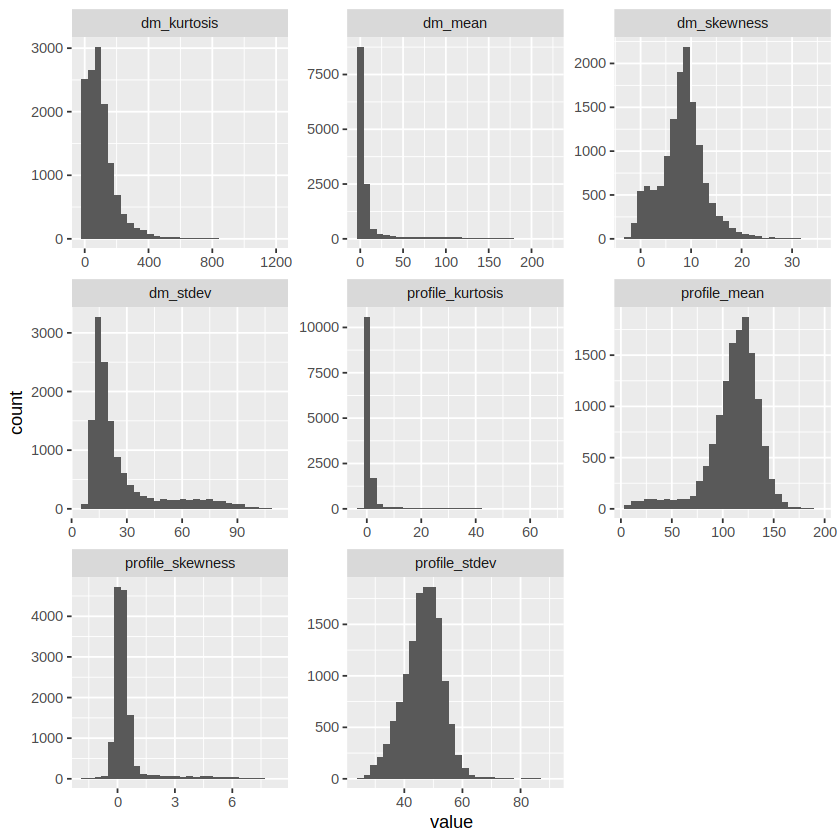

In [11]:
# visualize the data
long_data <- pulsar_train |>
    select(profile_mean:dm_kurtosis) |>
    gather(column_name, value)

hist_plots <- ggplot(long_data, aes(x = value)) +
    geom_histogram() +
    facet_wrap(~ column_name, scales = "free")

hist_plots

In [ ]:
# draw correlation heatmap
